In [1]:
# Importando bibliotecas

import os
import altair as alt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

# import time
import zipfile
import datetime
import requests, zipfile, io

plt.style.use('ggplot')
#mpl.style.use("seaborn-white")
# ['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']

sns.set_style("white") #darkgrid
sns.set(font='Liberation Sans')

In [2]:
# MELHORAR A RESOLUÇÃO DOS GRÁFICOS
%config InlineBackend.figure_format = 'svg' 

#### Coleta e Seleção dos Dados

In [3]:
## Microdados Enade 2019

QE2019 = pd.read_csv("microdados_enade_2019.txt", sep=";", decimal=",")
colunasSelecionadas2019 = ['NU_ANO', 'CO_REGIAO_CURSO','CO_GRUPO','CO_CURSO','CO_IES', 'CO_UF_CURSO', 'CO_CATEGAD', 'CO_ORGACAD', 'TP_PR_GER', 'TP_PRES','TP_PR_OB_FG', 'TP_PR_DI_FG', 'TP_PR_OB_CE', 'TP_PR_DI_CE','QE_I01', 'QE_I02', 'QE_I03', 'QE_I04','QE_I05', 'QE_I06', 'QE_I07', 'QE_I08', 'QE_I09', 'QE_I10','QE_I11', 'QE_I12', 'QE_I13','QE_I14', 'QE_I15', 'QE_I16', 'QE_I17','QE_I18','QE_I19','QE_I20','QE_I21','QE_I22','QE_I23', 'CO_RS_I1', 'CO_RS_I2','CO_RS_I7', 'CO_RS_I8', 'CO_RS_I9', 'NT_GER', 'NT_FG', 'NT_CE']
dados2019 = QE2019.filter(items = colunasSelecionadas2019)

# Recebe somente o grupo de Medicina, com a UFPA
med2019 = dados2019.loc[(dados2019['CO_GRUPO'] == 12)&(dados2019['TP_PRES'] == 555)&(dados2019['TP_PR_GER'] == 555)].dropna()

# Categoria administrativa: pública federal (10002); Categoria organizacional: universidade (10028)
med2019_UF = med2019.loc[(med2019['CO_CATEGAD'] == 10002)&(med2019['CO_ORGACAD'] == 10028)]

# Recebe somente os dados da UFPA
med2019_UFPA = med2019[med2019['CO_IES'] == 569]


## CPC 2019

ResultadoCPC2019 = pd.read_excel("resultados_cpc_2019.xlsx", sheet_name = 'CPC2019')
CPC2019 = ResultadoCPC2019[ResultadoCPC2019[' Código da Área'] == 12]
#CPC2019[' CPC (Contínuo)'] = CPC2019[' CPC (Contínuo)'].astype(float)

# Apenas Universidades Federais
CPC2019_UFBR = CPC2019.loc[(CPC2019[' Organização Acadêmica'] == 'Universidade') & (CPC2019[' Categoria Administrativa'] == 'Pública Federal')]

# Universidades Privada sem fins lucrativos
CPC2019_UParticular = CPC2019.loc[(CPC2019[' Organização Acadêmica'] == 'Universidade') & (CPC2019[' Categoria Administrativa'] == 'Privada sem fins lucrativos')] 

# Universidades Estaduais
CPC2019_UEstadual = CPC2019.loc[(CPC2019[' Organização Acadêmica'] == 'Universidade') & (CPC2019[' Categoria Administrativa'] == 'Pública Estadual')]

# UFPA
CPC2019_UFPA = CPC2019.loc[CPC2019[' Código da IES'] == 569]


alt.data_transformers.disable_max_rows()


DataTransformerRegistry.enable('default')

#### Tratamento e Limpeza dos dados

In [4]:
#Função para padronizar decimais como "."
def TrocaDecimal(x): 
  try: 
    if "," in str(x):
      return str(x).replace(",", ".")
    else:
      return x
  except:
    print(f"Erro:{x}")

#Função para tratar espaços vazios - importante para a consistência dos dados
def TrataEspaco(x):
   try:
    float(x)
    return float(x)
   except:
     return np.nan

#Tratando decimais e espaços em branco - Notas a serem analizadas
# Enade 2019 - Nota Bruta da Prova, Nota Bruta na Formação Geral e Nota Bruta no Componente Específico
dados2019["NT_GER"] = dados2019["NT_GER"].apply(TrocaDecimal)
dados2019["NT_GER"] = dados2019["NT_GER"].apply(TrataEspaco)
dados2019["NT_FG"] = dados2019["NT_FG"].apply(TrocaDecimal)
dados2019["NT_FG"] = dados2019["NT_FG"].apply(TrataEspaco)
dados2019["NT_CE"] = dados2019["NT_CE"].apply(TrocaDecimal)
dados2019["NT_CE"] = dados2019["NT_CE"].apply(TrataEspaco)

#### Análise de Correlação de Pearson (r) - CPC 2019

In [5]:
# Universidades Federais
corrUF = CPC2019_UFBR.filter(items = [' Organização Acadêmica', ' Categoria Administrativa',' Nota Padronizada - IDD',
                                  ' Conceito Enade (Contínuo)', ' CPC (Contínuo)',
                                  ' Nota Padronizada - Organização Didático-Pedagógica',
                                  ' Nota Padronizada - Infraestrutura e Instalações Físicas',
                                  ' Nota Padronizada - Oportunidade de Ampliação da Formação',
                                  ' Nota Padronizada - Mestres', ' Nota Padronizada - Doutores'])

# Renomeando as colunas - Universidades Federais
corrUF = corrUF.rename(columns={
    ' Conceito Enade (Contínuo)': 'ENADEc',
    ' CPC (Contínuo)': 'CPCc',
    ' Nota Padronizada - IDD': 'IDD',
    ' Nota Padronizada - Organização Didático-Pedagógica': 'ODP',
    ' Nota Padronizada - Infraestrutura e Instalações Físicas': 'IIF',
    ' Nota Padronizada - Oportunidade de Ampliação da Formação': 'OAF',
    ' Nota Padronizada - Mestres': 'PM',
    ' Nota Padronizada - Doutores': 'PD'
})

# Universidades Estatuais
corrUEstadual = CPC2019_UEstadual.filter(items = [' Organização Acadêmica', ' Categoria Administrativa',' Nota Padronizada - IDD', 
                                  ' Conceito Enade (Contínuo)',' CPC (Contínuo)',
                                  ' Nota Padronizada - Organização Didático-Pedagógica',
                                  ' Nota Padronizada - Infraestrutura e Instalações Físicas',
                                  ' Nota Padronizada - Oportunidade de Ampliação da Formação',
                                  ' Nota Padronizada - Mestres', ' Nota Padronizada - Doutores'])

# Renomeando as colunas - Universidades Estatuais
corrUEstadual = corrUEstadual.rename(columns={
    ' Conceito Enade (Contínuo)': 'ENADEc',
    ' CPC (Contínuo)': 'CPCc',
    ' Nota Padronizada - IDD': 'IDD',
    ' Nota Padronizada - Organização Didático-Pedagógica': 'ODP',
    ' Nota Padronizada - Infraestrutura e Instalações Físicas': 'IIF',
    ' Nota Padronizada - Oportunidade de Ampliação da Formação': 'OAF',
    ' Nota Padronizada - Mestres': 'PM',
    ' Nota Padronizada - Doutores': 'PD'
})

# Universidades Privada sem fins lucrativos
corrUParticular = CPC2019_UParticular.filter(items = [' Organização Acadêmica', ' Categoria Administrativa',' Nota Padronizada - IDD', 
                                  ' Conceito Enade (Contínuo)', ' CPC (Contínuo)',
                                  ' Nota Padronizada - Organização Didático-Pedagógica',
                                  ' Nota Padronizada - Infraestrutura e Instalações Físicas',
                                  ' Nota Padronizada - Oportunidade de Ampliação da Formação',
                                  ' Nota Padronizada - Mestres', ' Nota Padronizada - Doutores']) 

# Renomeando as colunas - Universidades Privada sem fins lucrativos
corrUParticular = corrUParticular.rename(columns={
    ' Conceito Enade (Contínuo)': 'ENADEc',
    ' CPC (Contínuo)': 'CPCc',
    ' Nota Padronizada - IDD': 'IDD',
    ' Nota Padronizada - Organização Didático-Pedagógica': 'ODP',
    ' Nota Padronizada - Infraestrutura e Instalações Físicas': 'IIF',
    ' Nota Padronizada - Oportunidade de Ampliação da Formação': 'OAF',
    ' Nota Padronizada - Mestres': 'PM',
    ' Nota Padronizada - Doutores': 'PD'
})

#### Universidades Privadas Sem Fins Lucrativos

In [6]:
corrUParticular.corr()

,IDD,ENADEc,ODP,IIF,OAF,PM,PD
IDD,1.000000,0.830985,0.552216,0.517636,0.426416,0.243566,0.190982
ENADEc,0.830985,1.000000,0.494400,0.544623,0.431786,0.245635,0.187492
ODP,0.552216,0.494400,1.000000,0.904627,0.857904,0.379801,0.170010
IIF,0.517636,0.544623,0.904627,1.000000,0.846661,0.470625,0.301518
OAF,0.426416,0.431786,0.857904,0.846661,1.000000,0.392781,0.153657
PM,0.243566,0.245635,0.379801,0.470625,0.392781,1.000000,0.849126
PD,0.190982,0.187492,0.170010,0.301518,0.153657,0.849126,1.000000


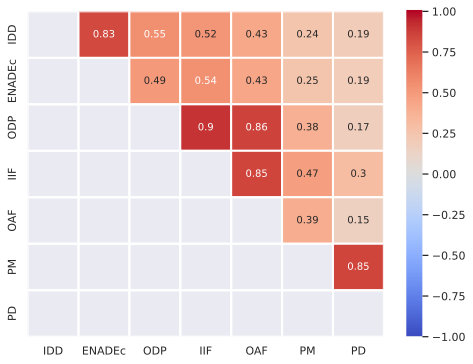

In [9]:
# Retirar Triângulo Inferior 
mask = np.tril(corrUParticular.corr())

# Retirar Triângulo Superior 
#mask = np.triu(rendimentoNP.corr())

plt.figure(figsize=(8, 6))
sns.heatmap(corrUParticular.corr(), annot = True, linewidth = 2, vmin = -1, vmax = 1, cmap='coolwarm', mask=mask)

# Salvar Gráfico em JPG
#plt.savefig('C:/Users/amara/Downloads/corruparticular_.jpg', format='jpg', dpi=500, bbox_inches='tight')

# Exibir o gráfico
#fig.tight_layout()
plt.show()

#### Universidades Federais

In [10]:
corrUF.corr()

,IDD,ENADEc,ODP,IIF,OAF,PM,PD
IDD,1.000000,0.693554,0.173561,0.113582,-0.082666,-0.363630,-0.215416
ENADEc,0.693554,1.000000,0.273078,0.292334,0.171024,0.007291,0.158769
ODP,0.173561,0.273078,1.000000,0.801719,0.659481,-0.150197,-0.009360
IIF,0.113582,0.292334,0.801719,1.000000,0.679629,-0.023910,0.090269
OAF,-0.082666,0.171024,0.659481,0.679629,1.000000,0.262292,0.334570
PM,-0.363630,0.007291,-0.150197,-0.023910,0.262292,1.000000,0.920566
PD,-0.215416,0.158769,-0.009360,0.090269,0.334570,0.920566,1.000000


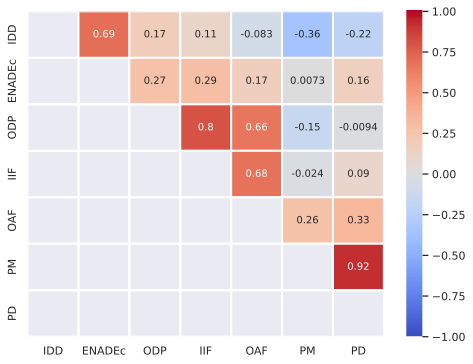

In [11]:
# Retirar Triângulo Inferior 
mask1 = np.tril(corrUF.corr())

plt.figure(figsize=(8, 6))
sns.heatmap(corrUF.corr(), annot = True, linewidth = 2, vmin = -1, vmax = 1, cmap='coolwarm', mask=mask1)

# Salvar Gráfico em JPG
#plt.savefig('C:/Users/amara/Downloads/corrUF_.jpg', format='jpg', dpi=500, bbox_inches='tight')

# Exibir o gráfico
#fig.tight_layout()
plt.show()

#### Universidades Estaduais

In [12]:
corrUEstadual.corr()

,IDD,ENADEc,ODP,IIF,OAF,PM,PD
IDD,1.000000,0.611105,0.052534,0.239060,0.297697,-0.054696,-0.026710
ENADEc,0.611105,1.000000,0.058257,0.220342,0.149488,0.287845,0.447444
ODP,0.052534,0.058257,1.000000,0.655008,0.619804,-0.143570,-0.008646
IIF,0.239060,0.220342,0.655008,1.000000,0.576327,-0.123430,0.175994
OAF,0.297697,0.149488,0.619804,0.576327,1.000000,-0.166093,-0.027361
PM,-0.054696,0.287845,-0.143570,-0.123430,-0.166093,1.000000,0.793135
PD,-0.026710,0.447444,-0.008646,0.175994,-0.027361,0.793135,1.000000


<AxesSubplot:>

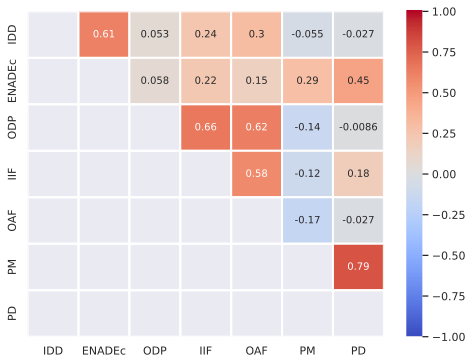

In [13]:
# Retirar Triângulo Inferior 
mask3 = np.tril(corrUEstadual.corr())

plt.figure(figsize=(8, 6))
sns.heatmap(corrUEstadual.corr(), annot = True, linewidth = 2, vmin = -1, vmax = 1, cmap='coolwarm', mask=mask3)

# Salvar Gráfico em JPG
#plt.savefig('C:/Users/amara/Downloads/corrUF_.jpg', format='jpg', dpi=500, bbox_inches='tight')

# Exibir o gráfico
#fig.tight_layout()
plt.show()

#### Gráfico de Barras Agrupadas 

In [46]:
def rotulos(barras):
    """
    Plota um gráfico de barras agrupadas mostrando a quantidade de alunos da UFPA
    que marcaram cada categoria das Questões 7 e 8 do Questionário de Percepção da
    Prova.
    
    Questão 7 (CO_RS_I7): Você se deparou com alguma dificuldade ao responder à prova. Qual?
                        A = Desconhecimento do conteúdo.
                        B = Forma diferente de abordagem do conteúdo.
                        C = Espaço insuficiente para responder às questões.
                        D = Falta de motivação para fazer a prova.
                        E = Não tive qualquer tipo de dificuldade para responder à prova.
                        * = Resposta anulada
                        . = Sem resposta
                        Valor em branco = Resposta não válida
    Questão 8 (CO_RS_I8): Considerando apenas as questões objetivas da prova, você percebeu que:
                        A = Não estudou ainda a maioria desses conteúdos.
                        B = Estudou alguns desses conteúdos, mas não os aprendeu.
                        C = Estudou a maioria desses conteúdos, mas não os aprendeu.
                        D = Estudou e aprendeu muitos desses conteúdos.
                        E = Estudou e aprendeu todos esses conteúdos.
                        * = Resposta anulada
                        . = Sem resposta
                        Valor em branco = Resposta não válida
    """
    for i in barras:
        h = i.get_height()
        ax.annotate('{}'.format(h),
                xy = (i.get_x()+i.get_width()/2, h),
                xytext = (0,3),
                textcoords = "offset points",
                ha = 'center',
                fontsize=10,
                color='gray')

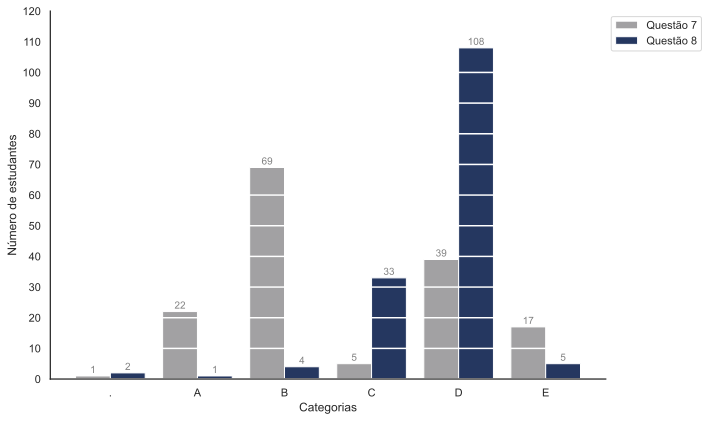

In [48]:
# Configurando o estilo do gráfico
sns.set_theme(style="white")

cinza_medio = "#A2A1A3"
azul_escuro = "#253760"

fig, ax = plt.subplots(figsize=(10,6))

# Contar e ordenar o índice (as letras) em ordem alfabética
qtdQP7 = med2019_UFPA["CO_RS_I7"].value_counts().sort_index()
qtdQP8 = med2019_UFPA["CO_RS_I8"].value_counts().sort_index()

categorias = [".", "A", "B", "C", "D", "E"]

# Criando um vetor para cada conjunto de dados (QP7 e QP8)
x = np.array(range(len(categorias)))  # Para que x corresponda ao número de categorias

# Remover bordas (grids e eixos)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

# Plotar barras antes e depois separadamente
width_bar = 0.40  # Tamanho da barra é 0.40, dividido por 2 para espaçamento
barras_qp7 = ax.bar(x - width_bar/2, qtdQP7, width_bar, label="Questão 7", color=cinza_medio)
barras_qp8 = ax.bar(x + width_bar/2, qtdQP8, width_bar, label="Questão 8", color=azul_escuro)

# Mostrar os rótulos dos eixos e a legenda do gráfico
ax.set_xlabel('Categorias')
ax.set_ylabel('Número de estudantes')
ax.legend()

# Mover a legenda para fora do gráfico
plt.legend(bbox_to_anchor=(1, 1), loc=2)

# Definir as posições dos ticks no eixo X e os rótulos
ax.set_xticks(x)
ax.set_xticklabels(categorias)

# Inserir os rótulos nas colunas
rotulos(barras_qp7)
rotulos(barras_qp8)

# Adicionar efeito de linhas nas barras
def adicionar_linhas_nas_barras(barras):
    for barra in barras:
        bar_x = barra.get_x()
        bar_width = barra.get_width()
        bar_height = barra.get_height()

        # Adicionar as linhas apenas dentro das barras
        for y in np.arange(0, bar_height, 10):  # Linhas a cada 10 unidades
            ax.plot([bar_x, bar_x + bar_width], [y, y], color='white')

plt.ylim(0,120)
ax.set_yticks(np.arange(0, 121, 10))
#ax.grid(axis = 'y', color ='gray', linestyle='--')

# Chamar a função para adicionar as linhas
adicionar_linhas_nas_barras(barras_qp7)
adicionar_linhas_nas_barras(barras_qp8)

# Salvar figura
# plt.savefig('C:/Users/amara/Downloads/QP7_QP8_.jpg', format='jpg', dpi=500, bbox_inches='tight')

# Exibir o gráfico
fig.tight_layout()
plt.show()